In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from functools import reduce
from scipy.stats import linregress
from scipy import fftpack
from scipy.signal import detrend
from tqdm import tqdm
from scipy.optimize import root_scalar
from tqdm import tqdm
from scipy.optimize import curve_fit
from tsmoothie.smoother import LowessSmoother
import matplotlib
from statsmodels.tsa.stattools import acf, pacf

In [2]:
'''
Cell size evolution m(t)
'''
def m_function(t, mb, omega1 = 1, v = 1):
    

    m_ = (mb)*np.exp(omega1*t)
    return m_


'''
Protein content evolution p(t)
'''
def p_function(t, mb, omega1 = 1, v = 1):
    

    
    p_ = (mb)*(np.exp(omega1*t) - 1)
    return p_


'''
Hazard rate function h(t)
'''
def h(t, mb, u, omega2, omega1 = 1, v = 1):

    h_ = omega2*((p_function(t, mb, omega1, v) + v)/(u+v)) # if p(t) ≥ mu
    h_[p_function(t, mb, omega1 = 1, v = 1) < u] = 0                 # if p(t) < mu
    
    return h_


'''
Logarithm of survival function s(t) for a float t
'''
def log_CDF_float(t, mb, u, omega2, omega1 = 1, v = 1):
    

    # threshold time
    t0 = (1.0/omega1) * np.log(1 + (u/mb))
    #t0 = max([0, (1.0/omega1) * np.log(1 + (mu/mb))])
    if t>=t0:
        ln_s_ = - ( (mb/(u+v)) * (omega2/omega1) * (np.exp(omega1*t)-np.exp(omega1*t0)) +\
                    ((v-mb)/(u+v)) * omega2 * (t-t0) )
    else:
        ln_s_ = 0

    return ln_s_


'''
Logarithm of survival function s(t) for an array t
'''
# threshold time

def log_CDF_arr(t, mb, u, omega2, omega1 = 1, v = 1):
    

    t0 = (1.0/omega1) * np.log(1 + (u/mb))
    

    ln_s_ = - ( (mb/(u+v)) * (omega2/omega1) * (np.exp(omega1*t)-np.exp(omega1*t0)) +((v-mb)/(u+v)) * omega2 * (t-t0) )
    
    
    
    ln_s_[t < t0] = 0                 # if p(t) < mu

    return ln_s_


'''
Logarithm of survival function s(t)
'''
def log_CDF(t, mb, u, omega2, omega1 = 1, v = 1):

    if type(t) == np.ndarray: # array
        ln_s_ = log_CDF_arr(t, mb, u, omega2, omega1, v)
    else: # float
        ln_s_ = log_CDF_float(t, mb, u, omega2, omega1, v)

    return ln_s_


'''
Survival function s(t)
'''
def CDF(t, mb, u, omega2, omega1 = 1, v = 1):
    return np.exp(log_CDF(t, mb, u, omega2, omega1, v))

'''
Find tau numerically
'''
def draw_tau_numerical(K, mb, u, omega2, omega1 = 1, v = 1):
    

    # threshold time
    t0 = max([0, (1.0/omega1) * np.log(1 + (u/mb))])


    sol = root_scalar(lambda t: CDF(t, mb = mb, u = u, omega2 = omega2, omega1 = omega1, v = v) - K, bracket=[t0, 40], method='brentq')
    tau = sol.root
    return tau

## Average size

In [3]:
def sizesAtBirth(omega2, omega1 = 1, mb0 = 1, u = 0, v = 1, seriesLength = 6000):
    pointsPerEvolution = 200 # Number of points per cell division
    sizesAtBirth = np.zeros(seriesLength)
    #timesAtBirth = np.zeros(seriesLength)
    
    
    s_drawn = np.random.uniform(low=0, high = 1, size = seriesLength)
    # Initialize the cell size array
    cellSizes = np.zeros(pointsPerEvolution*seriesLength)
    mb = mb0
    t = 0
    for i in range(seriesLength): 
        sizesAtBirth[i] = mb
        #parameters = (1,0.9,0.1,1,mb) # omega1, omega2, mu, nu, xb
        
        tau = draw_tau_numerical(s_drawn[i],  mb = mb, u = u, omega2 = omega2, omega1 = omega1, v = v)
        #sim_t.append(tau)

        # evolution
        times = np.linspace(0, tau, pointsPerEvolution)
        mt = m_function(times,  mb = mb, omega1 = omega1, v = v)
        # pt = p_function(times, parameters)
        
        # store times and sizes
        #all_times[i*points_per_evolution : (i+1)*points_per_evolution] = np.linspace(t, t+tau, points_per_evolution)
        cellSizes[i*pointsPerEvolution : (i+1)*pointsPerEvolution] = mt

        # update the initial time and the starting size
        mb = mt[-1]*(1/2)
        t = t+tau
    
    return sizesAtBirth, cellSizes


In [4]:
np.random.seed(2)
seriesesLength = [6000, 10000, 20000]
omega2Values = np.concatenate([np.linspace(0.001, 0.1, 25), np.linspace(0.11, 1.4, 50), np.linspace(1.41, 1/np.log(2), 25)])
simulate = True
load = True
if simulate:
    for seriesLength in tqdm(seriesesLength):
        meanSizesAtBirth = np.zeros(len(omega2Values))
        allSizes = np.zeros((len(omega2Values), seriesLength))
        for i, omega2 in enumerate(omega2Values):

            sizeBirth, _ = sizesAtBirth(omega2 = omega2, omega1 = 1, mb0 = 1, u = 0, v = 1, seriesLength = seriesLength)
            allSizes[i,:] = sizeBirth
            meanSizesAtBirth[i] = np.mean(sizeBirth)
            
            if np.allclose(sizeBirth[-1:], np.zeros(1)):
                treshold = i
                #print(f'The first case of an absorbing state is reached with omega2 = {omega2:.3}')
                absorbingValue = omega2
                break
        np.save(f'../data/sizeBirth_{seriesLength}.npy', allSizes)
        np.save(f'../data/meanSizeBirth_{seriesLength}.npy', meanSizesAtBirth)

100%|██████████| 3/3 [05:33<00:00, 111.25s/it]


In [5]:
if load:
    sizeBirth6000 = np.load(f'../data/sizeBirth_1100.npy')
    sizeBirth10000 = np.load(f'../data/sizeBirth_10000.npy')
    sizeBirth20000 = np.load(f'../data/sizeBirth_20000.npy')

In [6]:
criticalPoint = 1 / np.log(2)
def powerLaw(x, a, b):
    return a*x**b



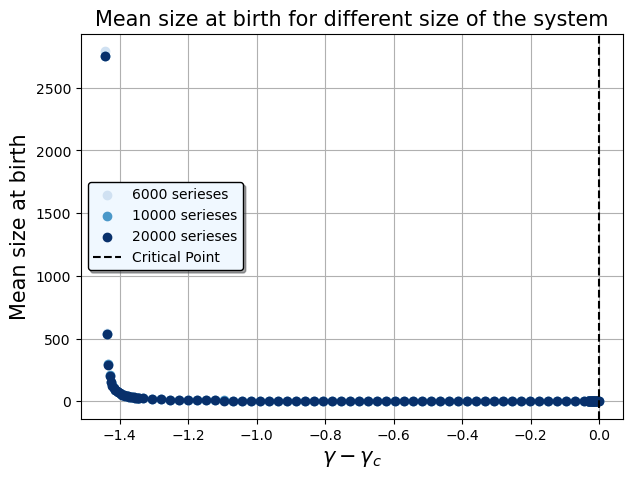

In [7]:
omega2BelowCritical = omega2Values[omega2Values < criticalPoint]
cmap = matplotlib.cm.get_cmap('Blues')
colors = [cmap(np.linspace(0.2, 1, len(seriesesLength)))[i] for i in range(len(seriesesLength))]
fig, ax  = plt.subplots(1,1, figsize = (7, 5))
for i, seriesLength in enumerate(seriesesLength):
    meanSizesAtBirth = np.load(f'../data/meanSizeBirth_{seriesLength}.npy')
    ax.scatter(omega2BelowCritical  - criticalPoint, meanSizesAtBirth[omega2Values < criticalPoint] ,\
                label = f'{seriesLength} serieses', color = colors[i], zorder = 2)

xAxis = np.linspace(0.001, np.max(omega2Values), 100)
popt, pcov = curve_fit(powerLaw, omega2BelowCritical, meanSizesAtBirth[omega2Values < criticalPoint] )
#ax.plot(xAxis - criticalPoint, powerLaw(xAxis, *popt), label = f'Power law fit: $a = {popt[0]:.3}$, $b = {popt[1]:.3}$')
#ax.axvline(absorbingValue - criticalPoint, color = 'red', linestyle = '--', zorder = 2)
ax.axvline(0, color = 'black', linestyle = '--', label = 'Critical Point', zorder = 2)
ax.set_xlabel('$\gamma - \gamma_c$', fontsize = 15, zorder = 2)
ax.set_ylabel('Mean size at birth', fontsize = 15, zorder = 2)
ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black')
ax.set_title('Mean size at birth for different size of the system', fontsize = 15)
ax.grid(zorder = 1)
plt.show()

/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_10316/872637864.py:3: RuntimeWarning: overflow encountered in power
  return a*x**b


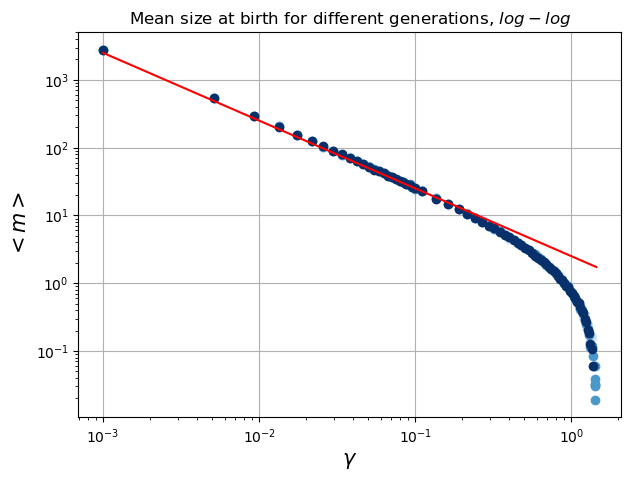

In [8]:
fig, ax  = plt.subplots(1,1, figsize = (7, 5))
for i, seriesLength in enumerate(seriesesLength):
    meanSizesAtBirth = np.load(f'../data/meanSizeBirth_{seriesLength}.npy')
    ax.scatter(omega2Values, meanSizesAtBirth, label = f'{seriesLength} generations', color = colors[i], zorder = 2)
ax.set_xlabel('$\gamma $', fontsize = 15)
ax.set_ylabel('$<m>$', fontsize = 15)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(zorder = 1)
popt, pcov = curve_fit(powerLaw, omega2Values[omega2Values < 1], meanSizesAtBirth[omega2Values < 1])
ax.plot(xAxis, powerLaw(xAxis, 2.5, -1), color = 'red')
#ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black')
ax.set_title('Mean size at birth for different generations, $log-log$')
plt.show()

## Correlation length

In the following we try to estimate how the correlation length scales approaching the critical point. To investigate finite size effects we also compute the autocorrelation function for simulations run fordifferent number of generations.\
The functional form we use to fit the correlation length is a power law, that catches the behaviour of the autocorrelation function near criticality, times an exponential which instead describes how the autocorrelation scales far away from the critical point.

<br/>

$$
acf(t) \quad = \quad t^{\nu} \cdot e^{-\frac{t}{\xi}}
$$

In [9]:
def autoCorrelationFunc(t, xi, n_c):
    return t**(-xi) * np.exp(-t/n_c)

# To account for negative values
def autoCorrelationFuncShift(t, xi, n_c, c):
    return t**(-xi) * np.exp(-t/n_c) + c

The correlation length found by the fit for 6000 generations and gamma = 0.0051 is: 8.01, the power law exponent is: 0.583
The correlation length found by the fit for 10000 generations and gamma = 0.0051 is: 6.95, the power law exponent is: 0.432
The correlation length found by the fit for 20000 generations and gamma = 0.0051 is: 7.78, the power law exponent is: 0.535
The correlation length found by the fit for 6000 generations and gamma = 1.4 is: 28.6, the power law exponent is: 0.171
The correlation length found by the fit for 10000 generations and gamma = 1.4 is: 1.67e+03, the power law exponent is: 0.456
The correlation length found by the fit for 20000 generations and gamma = 1.4 is: 3.21e+02, the power law exponent is: 0.409


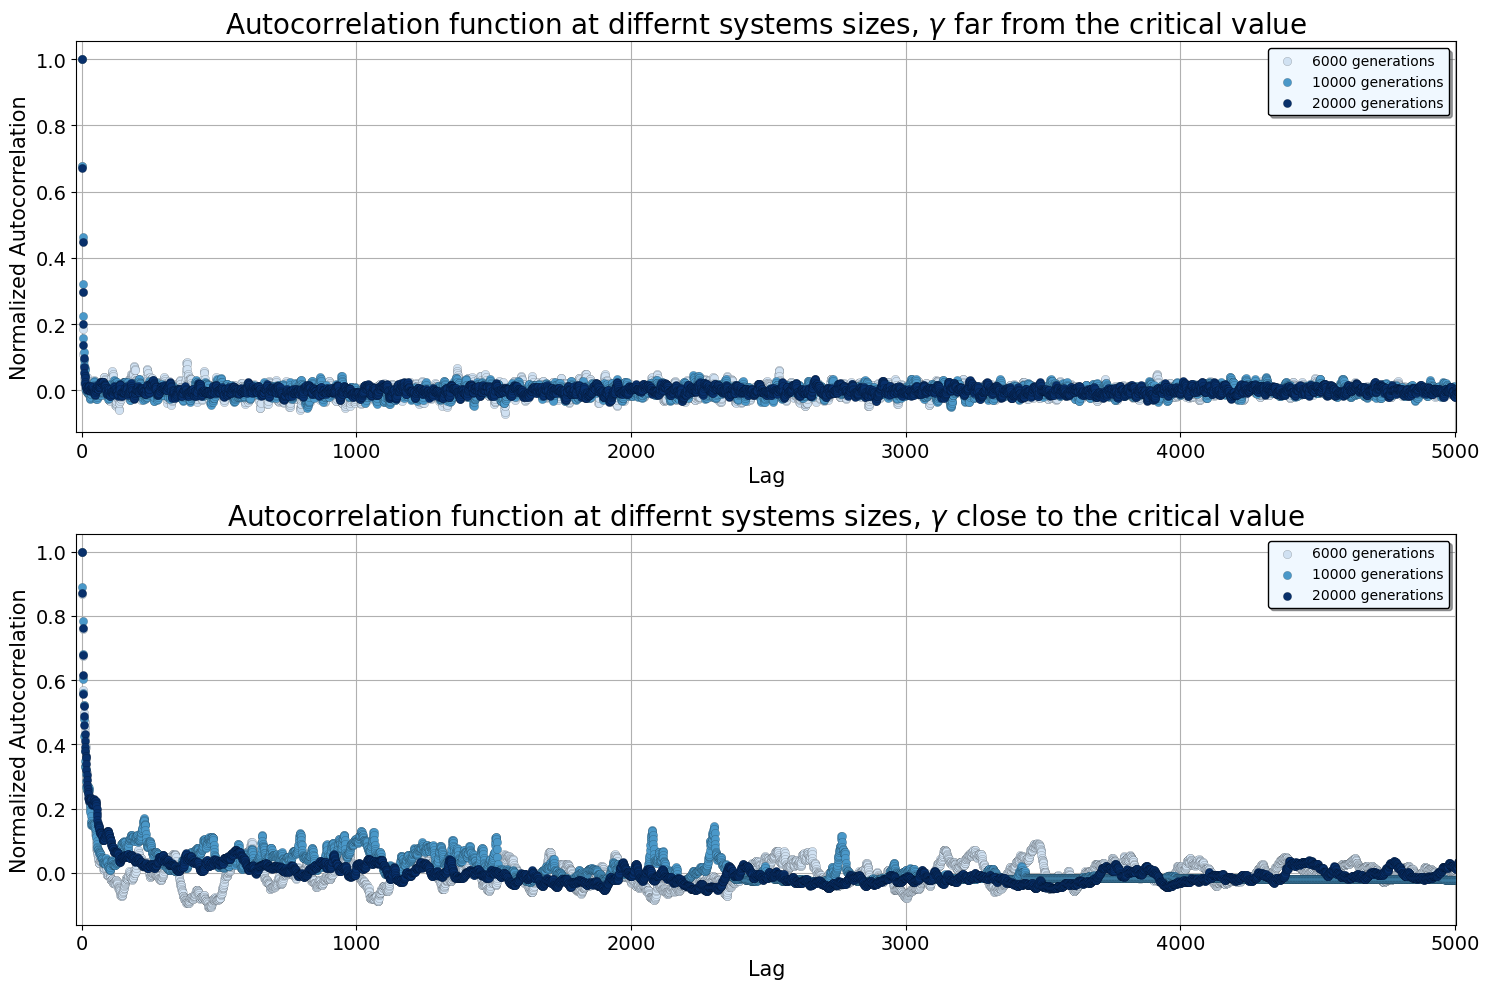

In [20]:
fig, ax_ = plt.subplots(2,1, figsize = (15, 10))
cArr = np.zeros((len(seriesesLength), 6000))
for ax, crit , pos in zip(ax_.flatten(), [1, -1], ['far from', 'close to']):
    for i, length in enumerate(seriesesLength):
        sizesAtBirth = np.load(f'../data/sizeBirth_{length}.npy')
        sizesAtBirth = sizesAtBirth[~np.all(sizesAtBirth == 0, axis=1)]
        sizesAtBirth = sizesAtBirth[crit]
        autocorrelation = acf(sizesAtBirth, nlags = 6000)
        #cArr[i, :] = c
        ax.scatter(range(1, len(autocorrelation) + 1), autocorrelation, label = f'{length} generations', edgecolor = 'black', linewidth = 0.1, zorder = 2, color = colors[i])
        u_x = list(range(1, 21))
        u_y = list(autocorrelation[:20])


        #Detect peaks  and mark their location in u_x,u_y

        for k in range(1,len(autocorrelation)-20):
            signRange = [(np.sign(autocorrelation[k]-autocorrelation[k-i])==1,\
                           np.sign(autocorrelation[k]-autocorrelation[k+i])==1) for i in range(1,20)]
            if all(list(map(lambda x: (x[0] and x[1]), signRange))):
                u_x.append(k)
                u_y.append(autocorrelation[k])

        #
        # print(u_y)
        #Append the last value of to the interpolating values
        #ax.plot(u_x, u_y, color = 'red', linestyle = '--', zorder = 2, label = 'Interpolated peaks')
        popt, pcov = curve_fit(autoCorrelationFunc, list(range(1, len(autocorrelation) + 1)), autocorrelation)
        #ax.plot(u_x, u_y, color = 'red')
        #ax.plot(list(range(1, len(autocorrelation) + 1)), autoCorrelationFunc(np.array(range(1, len(autocorrelation) + 1)), *popt),\
         #       color = 'red', linestyle = '--', zorder = 2)
        print(f'The correlation length found by the fit for {length} generations and gamma = {omega2BelowCritical[crit]:.2}\
 is: {popt[1]:.3}, the power law exponent is: {popt[0]:.3}')
    ax.set_xlim(-20, 5005)
    ax.grid(zorder = 1)
    ax.legend(facecolor = 'aliceblue', edgecolor = 'black', shadow = True, loc = 'best')
    ax.set_xlabel('Lag', fontsize = 15)
    ax.set_ylabel('Normalized Autocorrelation', fontsize = 15)
    ax.tick_params(labelsize = 14)
    ax.set_title(f'Autocorrelation function at differnt systems sizes, $\gamma$ {pos} the critical value', fontsize = 20)
fig.tight_layout()

In [18]:
shift = True
SizesAtBirth6000 = np.load(f'../data/SizeBirth_6000.npy')
SizesAtBirth6000 = SizesAtBirth6000[~np.all(SizesAtBirth6000 == 0, axis=1)]
#fig, ax = plt.subplots(1, 1, figsize = (15, 5))

corrLengths = np.zeros(SizesAtBirth6000.shape[0])
exponentN = np.zeros(SizesAtBirth6000.shape[0])
for i in tqdm(range((SizesAtBirth6000.shape[0]))):
    autocorrelation = acf(SizesAtBirth6000[i], nlags = 4000)
    #ax.plot(list(range(len(autocorrelation))), autocorrelation, label = f'Generation {i}')
    u_x = list(range(1, 21))
    u_y = list(autocorrelation[:20])


    #Detect peaks  and mark their location in u_x,u_y

    for k in range(1,len(autocorrelation)-20):
        signRange = [(np.sign(autocorrelation[k]-autocorrelation[k-i])==1,\
                        np.sign(autocorrelation[k]-autocorrelation[k+i])==1) for i in range(1,20)]
        if all(list(map(lambda x: (x[0] and x[1]), signRange))):
            u_x.append(k)
            u_y.append(autocorrelation[k])
    
    popt, pcov = curve_fit(autoCorrelationFunc, list(range(1, len(autocorrelation) + 1)), autocorrelation)
    
    #ax.plot(autoCorrelationFunc(np.linspace(0.1, len(autocorrelation), 100), *popt), label = f'Fit for generation {i}', color = 'black')
    exponentN[i] = popt[0]
    corrLengths[i] = popt[1]

100%|██████████| 73/73 [00:14<00:00,  5.08it/s]


In [19]:
SizesAtBirth10000 = np.load(f'../data/SizeBirth_10000.npy')
SizesAtBirth10000 = SizesAtBirth10000[~np.all(SizesAtBirth10000 == 0, axis=1)]


corrLengths10000 = np.zeros(SizesAtBirth10000.shape[0])
exponentN10000 = np.zeros(SizesAtBirth10000.shape[0])
for i in tqdm(range((SizesAtBirth10000.shape[0]))):
    autocorrelation = acf(SizesAtBirth10000[i], nlags = 4000)
    #ax.plot(list(range(len(autocorrelation))), autocorrelation, label = f'Generation {i}')
    u_x = list(range(1, 21))
    u_y = list(autocorrelation[:20])


    #Detect peaks  and mark their location in u_x,u_y

    for k in range(1,len(autocorrelation)-20):
        signRange = [(np.sign(autocorrelation[k]-autocorrelation[k-i])==1,\
                        np.sign(autocorrelation[k]-autocorrelation[k+i])==1) for i in range(1,20)]
        if all(list(map(lambda x: (x[0] and x[1]), signRange))):
            u_x.append(k)
            u_y.append(autocorrelation[k])
    
    popt, pcov = curve_fit(autoCorrelationFunc, list(range(1, len(autocorrelation) + 1)), autocorrelation)
    corrLengths10000[i] = popt[1]
    exponentN10000[i] = popt[0]


100%|██████████| 81/81 [00:19<00:00,  4.16it/s]


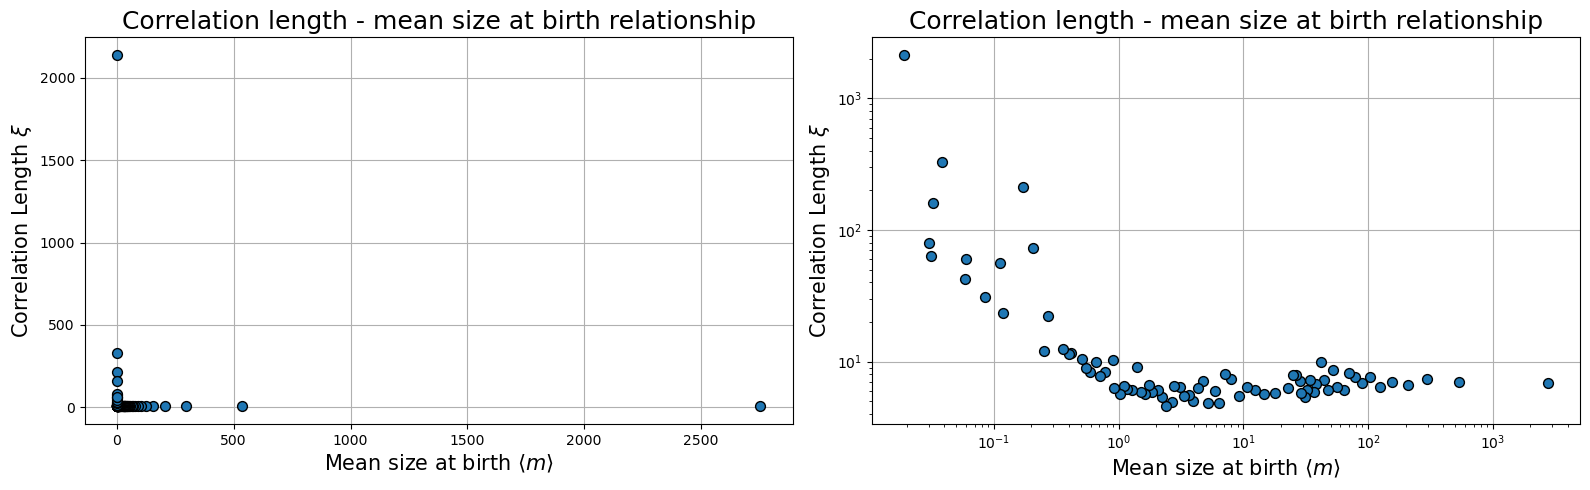

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
meanSizesAtBirth10000 = np.load(f'../data/meanSizeBirth_{10000}.npy')
for ax, axis in zip(ax.flatten(), ['linear', 'log']):
    ax.scatter(meanSizesAtBirth10000[meanSizesAtBirth10000 > 0], corrLengths10000, edgecolor = 'black', s = 50, zorder = 2)
    #ax.set_ylim(bottom = bottom, top = top)
    ax.grid(zorder = 1)
    ax.set_xlabel('Mean size at birth $\\langle m \\rangle$', fontsize = 15)
    ax.set_ylabel('Correlation Length $\\xi$', fontsize = 15)
    ax.set_title('Correlation length - mean size at birth relationship', fontsize = 18)
    ax.set_xscale(axis)
    ax.set_yscale(axis)
#ax.set_xscale('log')
#ax.set_yscale('log')
fig.tight_layout()

Text(0.5, 1.0, 'Correlation length approaching the critical point')

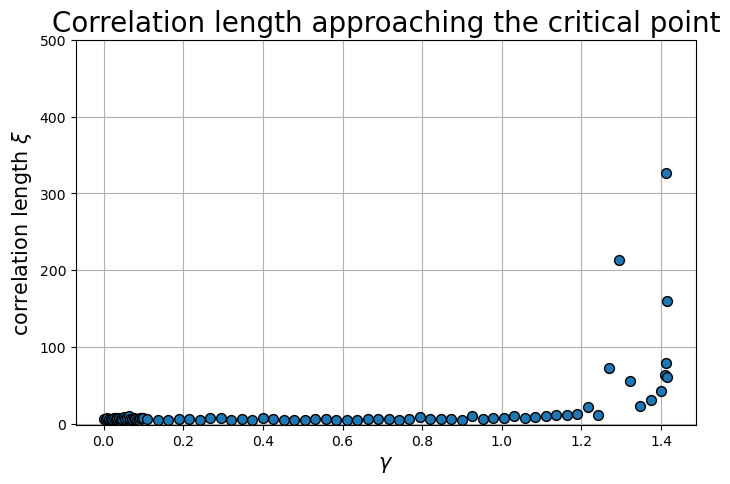

In [32]:
limit = True
(top, bottom) = (4e4, 0) if limit else (None, None)
omega2Values10000 = omega2Values[:SizesAtBirth10000.shape[0]]
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
ax.scatter(omega2Values10000, corrLengths10000, edgecolor = 'black', s = 50, zorder = 2)
ax.set_ylim(top = 500, bottom = -1)
ax.grid(zorder = 1)
ax.set_xlabel('$\\gamma$', fontsize = 15)
ax.set_ylabel('correlation length $\\xi$', fontsize = 15)
ax.set_title('Correlation length approaching the critical point', fontsize = 20)


Text(0.5, 1.0, 'Exponent $\\eta$ approaching the critical point')

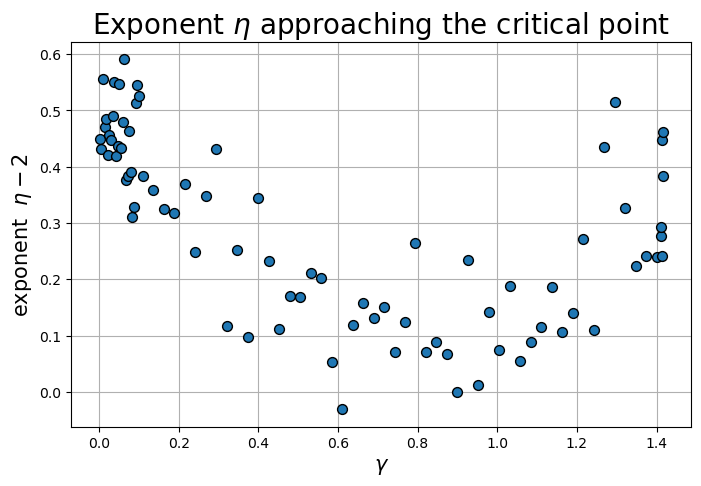

In [34]:
limit = True
(top, bottom) = (4e4, 0) if limit else (None, None)
absorbingThreshold = 34

fig, ax = plt.subplots(1, 1, figsize = (8, 5))
ax.scatter(omega2Values10000, exponentN10000, edgecolor = 'black', s = 50, zorder = 2)
#ax.set_ylim(bottom = bottom,top = top)
ax.grid(zorder = 1)
ax.set_xlabel('$\\gamma$', fontsize = 15)
ax.set_ylabel('exponent  $\\eta - 2$', fontsize = 15)
ax.set_title('Exponent $\\eta$ approaching the critical point', fontsize = 20)


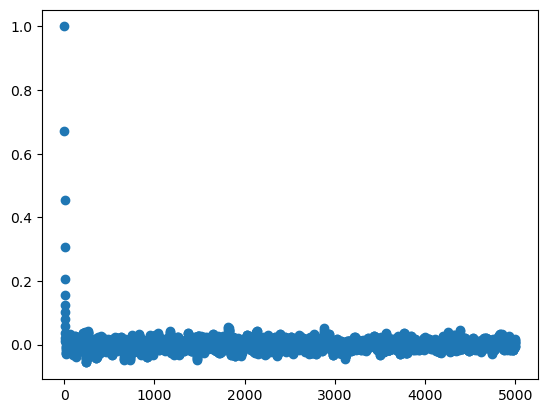

In [45]:
plt.scatter(list(range(1, len(autocorrelation) + 1)), autocorrelation)

The correlation length retrieved by the fit at gamma 1.4 is: 1.6e+03
The correlation length retrieved by the fit at gamma 1.4 is: 6.9


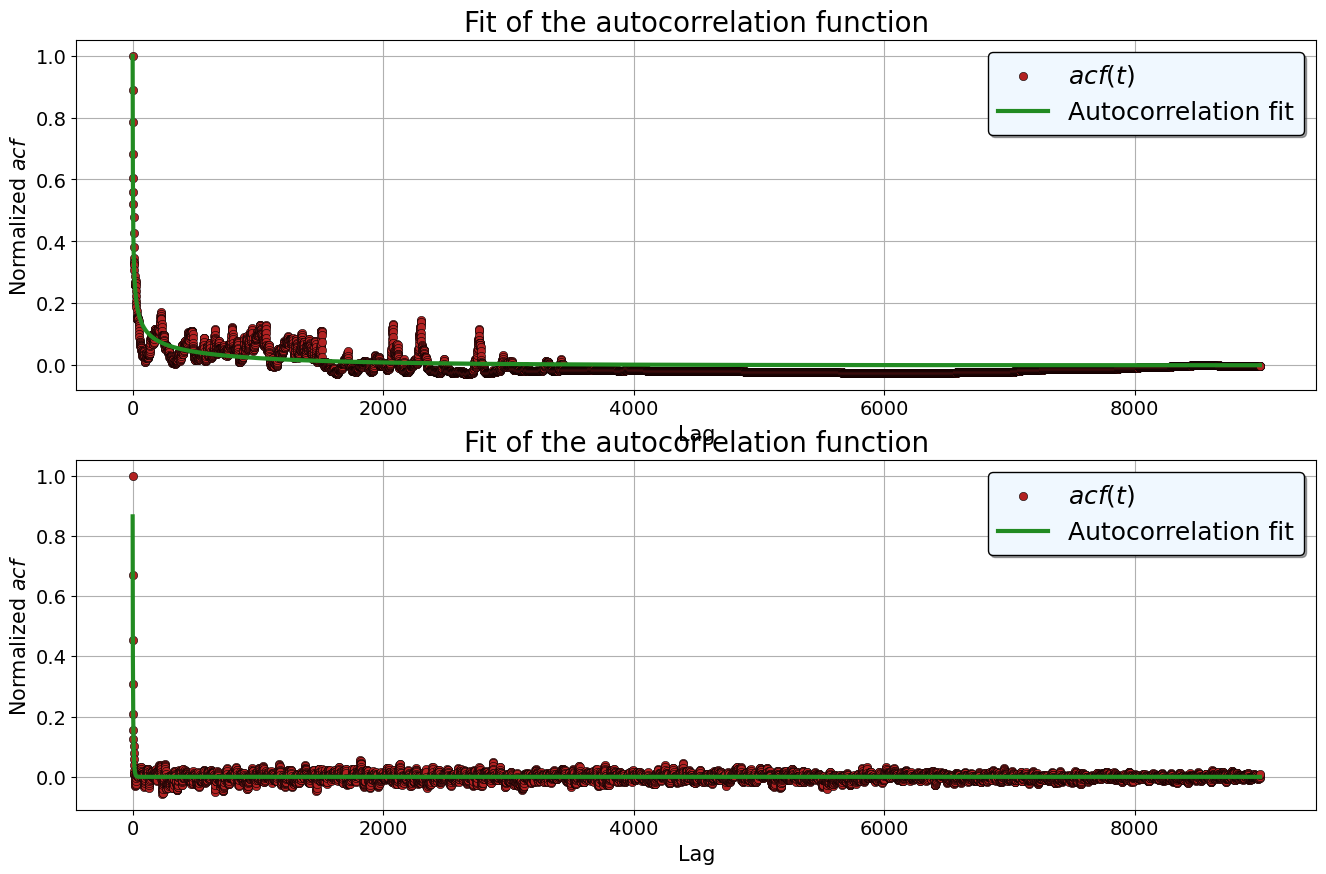

In [57]:
fig, ax = plt.subplots(2, 1, figsize = (16, 10))
for ax, crit in zip(ax.flatten(), [-1, 0]):
    autocorrelation = acf(SizesAtBirth10000[crit], nlags = 9000)
    
    



    #Detect peaks  and mark their location in u_x,u_y

    
    ax.scatter(list(range(1, len(autocorrelation) + 1)), autocorrelation, color = 'firebrick', alpha = 1, edgecolor = 'black', linewidth = 0.4, zorder = 2, label = '$acf (t)$')
    popt, pcov = curve_fit(autoCorrelationFunc, list(range(1, len(autocorrelation) + 1)), autocorrelation)
    
    ax.plot(list(range(1, len(autocorrelation) + 1)), autoCorrelationFunc(np.array(range(1, len(autocorrelation) + 1)), *popt),\
             color = 'forestgreen', linewidth = 3, label = 'Autocorrelation fit')
    ax.grid(zorder = 1)
    ax.set_xlabel('Lag', fontsize = 15)
    ax.set_ylabel('Normalized $acf$', fontsize = 15)
    ax.tick_params(labelsize = 14)
    ax.set_title('Fit of the autocorrelation function', fontsize = 20)
    ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', fontsize = 18)
    #ax.plot(u_x, u_y, color = 'fuchsia', linewidth = 3)
    print(f'The correlation length retrieved by the fit at gamma {omega2Values10000[-1]:.2} is: {popt[1]:.2}')
#fig.tight_layout()    

In [ ]:
def correlationLength(omega2, omega1 = 1, mb0 = 0.5, u = 0.1, v = 1, plot = False, includeFirst = 1):
    seriesLength = 6000 # Length of the time series
    pointsPerEvolution = 200 # Number of points per cell division
    sizesAtBirth = np.zeros(seriesLength)
    #timesAtBirth = np.zeros(seriesLength)
    lags = 1000
    
    s_drawn = np.random.uniform(low=0, high = 1, size = seriesLength)
    # Initialize the cell size array
    cellSizes = np.zeros(pointsPerEvolution*seriesLength)
    mb = mb0
    t = 0
    for i in range(seriesLength): 
        sizesAtBirth[i] = mb
        #parameters = (1,0.9,0.1,1,mb) # omega1, omega2, mu, nu, xb
        tau = draw_tau_numerical(s_drawn[i],  mb = mb, u = u, omega2 = omega2, omega1 = omega1, v = v)
        #sim_t.append(tau)

        # evolution
        times = np.linspace(0, tau, pointsPerEvolution)
        mt = m_function(times,  mb = mb, omega1 = omega1, v = v)
        # pt = p_function(times, parameters)
        
        # store times and sizes
        #all_times[i*points_per_evolution : (i+1)*points_per_evolution] = np.linspace(t, t+tau, points_per_evolution)
        cellSizes[i*pointsPerEvolution : (i+1)*pointsPerEvolution] = mt

        # update the initial time and the starting size
        mb = mt[-1]*(1/2)
        t = t+tau

    allTimes = np.linspace(0, t, pointsPerEvolution*seriesLength)

    lags, c, _, _ = plt.acorr(sizesAtBirth, maxlags = lags, color = 'firebrick', usevlines = False, normed = True)
    plt.cla()
#ax.set_xlim(left = -0.1)
    
    lagsGt = lags[lags > 0]
    cGt = c[lags > 0]
    
    

    #q_u = np.zeros(cGt.shape)

    #Prepend the first value of (s) to the interpolating values

    u_x = [0,]
    u_y = [cGt[0],]


    #Detect peaks  and mark their location in u_x,u_y

    for k in range(1,len(cGt)-20):
        signRange = [(np.sign(cGt[k]-cGt[k-i])==1, np.sign(cGt[k]-cGt[k+i])==1) for i in range(1,20)]
        if all(list(map(lambda x: (x[0] and x[1]), signRange))):
            u_x.append(k)
            u_y.append(cGt[k])


    #Append the last value of to the interpolating values


    u_x.append(len(cGt)-1)
    u_y.append(cGt[-1])



    #u_p = interp1d(u_x,u_y, kind = 'cubic',bounds_error = False, fill_value=0.0)

    slope, intercept, r, p, se = linregress(u_x[1-includeFirst:], np.log10(u_y[1-includeFirst:]))
    corrLength = -np.log10(np.exp(1))/slope


    if not plot:
        plt.clf()
    else:
        plt.scatter(lags[lags > 0], np.log10(c[lags > 0]), color = 'firebrick', edgecolor = 'black', alpha = 0.8, linewidth = 0.5)
        plt.plot([lagsGt[0]] + list(u_x[1:]), np.log10([cGt[0]] + list(u_y[1:])), color = 'navy', linewidth = 3)
        plt.plot([lagsGt[0]] + list(u_x[1:]), slope*np.array([lagsGt[0]] + list(u_x[1:])) + intercept, color = 'forestgreen', linewidth = 3)

    return corrLength, cGt



